# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/robot/Documents/_projects/Cannabis")

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('/media/robot/Storage/images/NAIP_Imagery/2016_1024x_CNNabis/logs'
                               '/cnnabis_naip_201620190311T1847', "mask_rcnn_cnnabis_naip_2016_0023.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    #utils.download_trained_weights(COCO_MODEL_PATH)
    print("Could not find model")
    assert os.path.exists(COCO_MODEL_PATH)

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")
IMAGE_DIR = os.path.join('/media/robot/Storage/images/NAIP_Imagery/2016_1024x_CNNabis/train2016')

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class CNNabisConfig(Config):
    """Configuration for inference on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CNNabis_inference"
    
    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # CNNabis has 6 classes + 1 back ground

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 312)  # anchor side in pixels

    # 4-band modifications.
    # alter utils.py in mrcnn folder, line 364 to leave 4 band in place
    # for 4-band images
    # IMAGE_CHANNEL_COUNT = 4
    # adjust the mean pixel value for alpha-band, I just made up 100.0
    # MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 100.0])

    # Detection values
    DETECTION_MIN_CONFIDENCE = 0.60

    # switch to ResNet 50 instead of 101
    #BACKBONE = "resnet50"


config = CNNabisConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)#, exclude[''])

Re-starting from epoch 23


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
# We'll have to figure out the right order... it may come from train or val... currently these don't match :(
class_names = ['BG', 'Greenhouse', 'Pond', 'Water tank','Active Cannabis Cultivation', 'Inactive Cannabis Cultivation', 'Debris']

## Run Object Detection

m_3912339_sw_10_h_20160531_5_2.JPEG
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    8.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -115.70000  max:  124.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.21566  max:    1.15310  float32


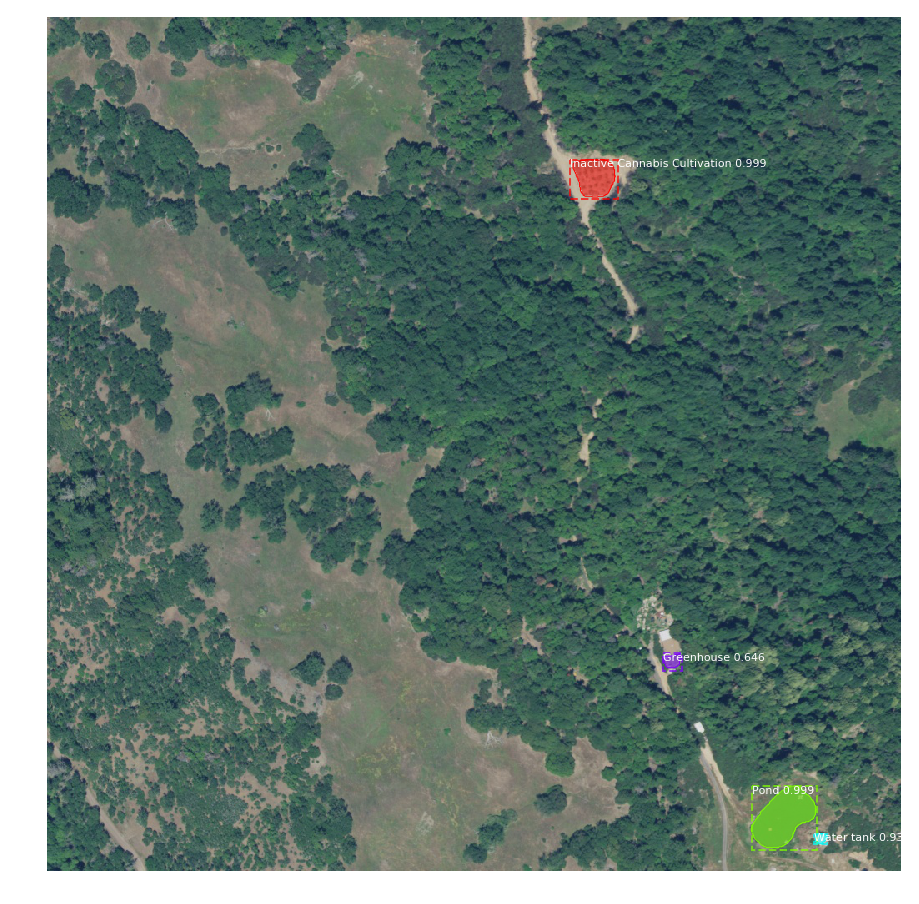

In [14]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
img_choice = random.choice(file_names)
print(img_choice)
image = skimage.io.imread(os.path.join(IMAGE_DIR, img_choice ))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
